## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [37]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [38]:
train, test = keras.datasets.cifar10.load_data()

In [39]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [40]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [41]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [42]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [43]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4.,weight=0):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=0)
        reduced_ce = tf.reduce_max(ce, axis=0)
        return tf.reduce_mean(weight*reduced_fl+(1-weight)*reduced_ce)
    return focal_loss_fixed

In [44]:
weights = [0., 0.3, 0.5, 0.7, 1]

In [45]:
import itertools
results = {}

for i, weight in enumerate(weights):
    print("Numbers of exp: %i, weight: %.2f" % (i, weight))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(weight=weight), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, weight: 0.00
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_11

49/49 [==============================] - 3s 68ms/step - loss: 2.8578 - accuracy: 0.2276 - val_loss: 2.8942 - val_accuracy: 0.1921
Epoch 14/25
49/49 [==============================] - 4s 73ms/step - loss: 2.8543 - accuracy: 0.2239 - val_loss: 2.9156 - val_accuracy: 0.2287
Epoch 15/25
49/49 [==============================] - 3s 67ms/step - loss: 2.8514 - accuracy: 0.2270 - val_loss: 2.8906 - val_accuracy: 0.2203
Epoch 16/25
49/49 [==============================] - 3s 68ms/step - loss: 2.8334 - accuracy: 0.2326 - val_loss: 2.8777 - val_accuracy: 0.2356
Epoch 17/25
49/49 [==============================] - 3s 68ms/step - loss: 2.8308 - accuracy: 0.2244 - val_loss: 2.8653 - val_accuracy: 0.2083
Epoch 18/25
49/49 [==============================] - 3s 71ms/step - loss: 2.8308 - accuracy: 0.2268 - val_loss: 2.8539 - val_accuracy: 0.2411
Epoch 19/25
49/49 [==============================] - 3s 71ms/step - loss: 2.8272 - accuracy: 0.2205 - val_loss: 2.8593 - val_accuracy: 0.1857
Epoch 20/25
49/49 

Epoch 1/25
49/49 [==============================] - 3s 70ms/step - loss: 5.6285 - accuracy: 0.1729 - val_loss: 8.0384 - val_accuracy: 0.0974
Epoch 2/25
49/49 [==============================] - 3s 64ms/step - loss: 3.5379 - accuracy: 0.2053 - val_loss: 4.0641 - val_accuracy: 0.1278
Epoch 3/25
49/49 [==============================] - 3s 65ms/step - loss: 3.1648 - accuracy: 0.1992 - val_loss: 3.5088 - val_accuracy: 0.1421
Epoch 4/25
49/49 [==============================] - 3s 67ms/step - loss: 3.0434 - accuracy: 0.2180 - val_loss: 3.1850 - val_accuracy: 0.1786
Epoch 5/25
49/49 [==============================] - 3s 69ms/step - loss: 2.9842 - accuracy: 0.2214 - val_loss: 3.0616 - val_accuracy: 0.1795
Epoch 6/25
49/49 [==============================] - 3s 64ms/step - loss: 2.9560 - accuracy: 0.2211 - val_loss: 3.0065 - val_accuracy: 0.2045
Epoch 7/25
49/49 [==============================] - 3s 64ms/step - loss: 2.9249 - accuracy: 0.2253 - val_loss: 3.0042 - val_accuracy: 0.2167
Epoch 8/25
49

49/49 [==============================] - 3s 64ms/step - loss: 2.8215 - accuracy: 0.2144 - val_loss: 2.8389 - val_accuracy: 0.2090
Epoch 24/25
49/49 [==============================] - 3s 66ms/step - loss: 2.8147 - accuracy: 0.2186 - val_loss: 2.8288 - val_accuracy: 0.2262
Epoch 25/25
49/49 [==============================] - 3s 67ms/step - loss: 2.8177 - accuracy: 0.2194 - val_loss: 2.8471 - val_accuracy: 0.2152


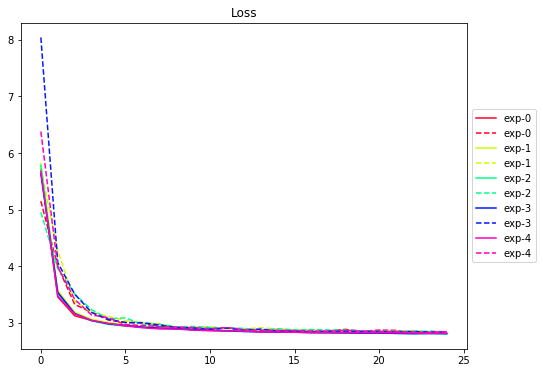

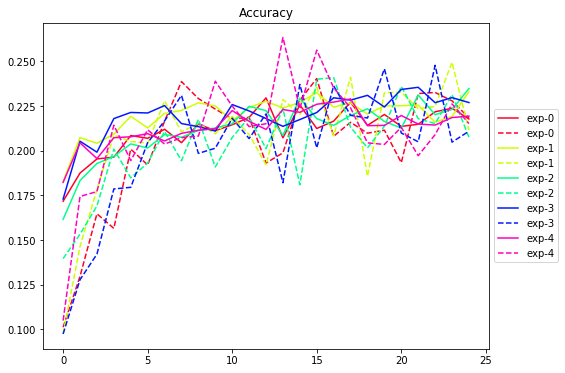

In [46]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()